In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('BetterVectorList_V2.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]
BetterVector = Slist['BetterVectors'][()]

In [5]:
TdayTotalIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3)

In [6]:
def getAllLastP_centre(fofID, centralID, betterVector):
    """
    get position of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the "Better Vector".
    """
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []

    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    Idlist = np.unique(Idlist) # remove duplicates
    
    TdayOff = sim['SnapNumber_127/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #cut at a certain distance
    distance = 600 # distance in ckpc

    posGal = sim['SnapNumber_127/SubGroups/SubGroupPos'][fofID]
#     posCen = sim['SnapNumber_127/SubGroups/SubGroupPos'][centralID]
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][centralID]

    posCen = sim['SnapNumber_128/Groups/GroupCM'][group]

    LostCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
#     GasMasses = sim['SnapNumber_127/PartType0/Masses'][IndexT_near]
#     GassAbundances = sim['SnapNumber_127/PartType0/Abundances'][IndexT_near]
    
    NearCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_near]

    #re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
#     xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    xc, yc, zc = betterVector[0], betterVector[1], betterVector[2]

    # teh rotation matrix for the direction of the better vector
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    #the rotated coordinates
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
#     xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    # return the 2 sets of rotated positions, masses and abundances
#     return xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GassAbundances # not yet
#     return xRv, yRv, zRv, xRc, yRc, zRc 
    return xRc, yRc, zRc

In [7]:
import progressbar

100% (20 of 20) |########################| Elapsed Time: 0:12:25 ETA:  00:00:00

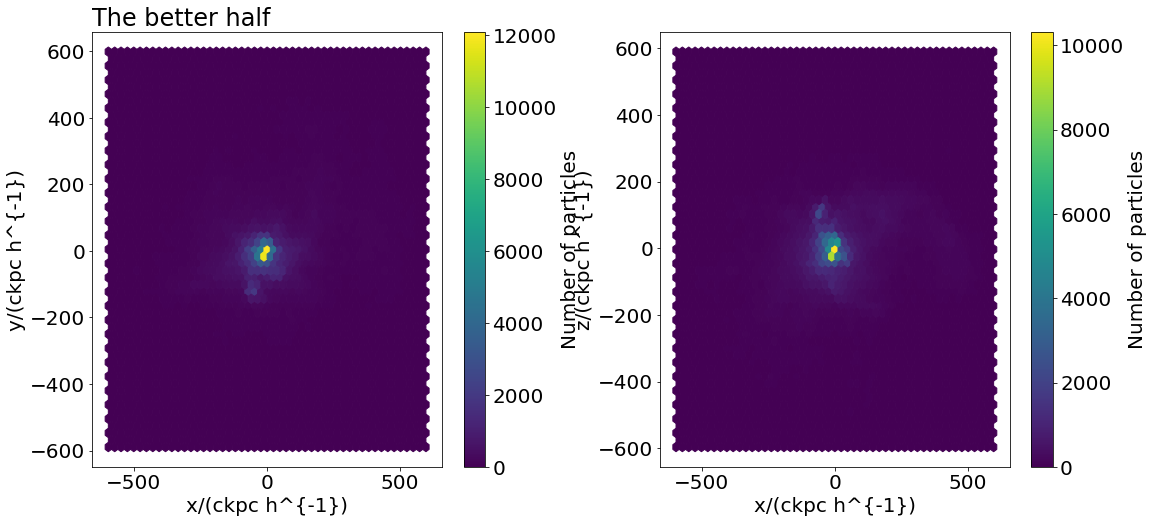

In [8]:
# no separation, there's not enough galaxies
size = Satellites.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

XRc, YRc, ZRc = [], [], []

for ff, cc, vv in zip(Satellites, Centrals, BetterVector):
    xRc, yRc, zRc = getAllLastP_centre(ff, cc, vv)
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    C += 1
    bar.update(C)
    
XRc, YRc, ZRc = np.array(XRc), np.array(YRc), np.array(ZRc)

pl.figure(figsize=(18, 8))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(1, 2, 1)

pl.title('The better half', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(1, 2, 2)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')